In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['vector_size'] = 2
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_spec['sc_eps'] = 1

# PG-EXTRA hyperparameters
problem_data['rho'] = 2.5
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 2}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.min(s)])

[2.7129369006676245, 0.24402904113379548]
[2.6812456843234003, 0.4635678688976332]
[2.5621183120218145, 0.00019478897099736166]
[3.3351287370304052, 0.14769862660468408]
[1.075934170836037, 0.4922459478302828]
[2.8351767469757183, 0.0011491329420762442]


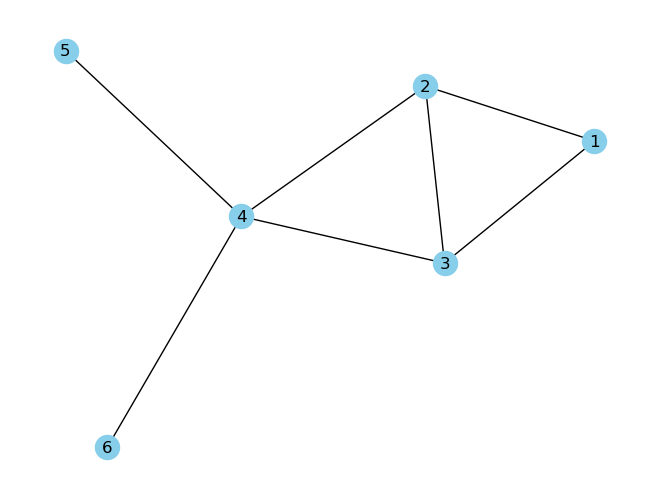

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.07903429113113261, np.linalg.norm(x_opt_star)=0.12640334557947475


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0790342911311326, np.linalg.norm(x_opt_star)=0.12640334557947472


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
eps = problem_spec['sc_eps']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set={3,4}, freq=200)

ii=0, f_reldiff[-1]=106.32638496729753
ii=200, f_reldiff[-1]=1.4705131373400207e-09
ii=400, f_reldiff[-1]=1.7383606195620505e-14
ii=600, f_reldiff[-1]=1.6681238268524727e-14
ii=800, f_reldiff[-1]=1.7383606195620505e-14
ii=999, f_reldiff[-1]=1.7383606195620505e-14


In [9]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
dadmm_c_all_err_opt_star, dadmm_c_all_err_opt_reldiff, dadmm_c_all_const_vio, dadmm_c_all_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set={1,2,3,4,5,6}, freq=200)

ii=0, f_reldiff[-1]=106.32638496729753
ii=200, f_reldiff[-1]=1.2413220543135432e-09
ii=400, f_reldiff[-1]=1.2818214669497947e-14
ii=600, f_reldiff[-1]=1.2818214669497947e-14
ii=800, f_reldiff[-1]=1.2818214669497947e-14
ii=999, f_reldiff[-1]=1.2818214669497947e-14


In [10]:
# R = 18
# R = 1
R = 2
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=106.32638496729753
ii=200, f_reldiff[-1]=1.492756116952185e-06
ii=400, f_reldiff[-1]=9.885828573873075e-14
ii=600, f_reldiff[-1]=1.7383606195620505e-14
ii=800, f_reldiff[-1]=1.7383606195620505e-14
ii=999, f_reldiff[-1]=1.7383606195620505e-14


In [11]:
# apply P-EXTRA 
# problem_data['rho'] = 1
# problem_data['rho'] = 0.5
problem_data['rho'] = 0.1
# problem_data['rho'] = 0.01
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=86.27374359424523, err_opt_reldiff[-1]=0.539557499351197
ii=200, f_reldiff[-1]=5.065933830158259e-05, err_opt_reldiff[-1]=7.771224453040677e-07
ii=400, f_reldiff[-1]=8.95619194476728e-11, err_opt_reldiff[-1]=1.2228186365143594e-12
ii=600, f_reldiff[-1]=1.2291438724176114e-15, err_opt_reldiff[-1]=5.720648884550304e-15
ii=800, f_reldiff[-1]=2.633879726609167e-15, err_opt_reldiff[-1]=5.873200074907932e-15
ii=999, f_reldiff[-1]=2.633879726609167e-15, err_opt_reldiff[-1]=5.8732047899063614e-15


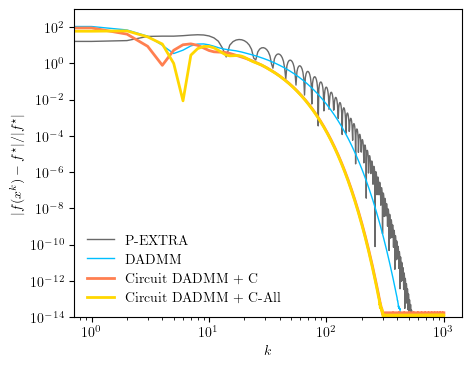

In [13]:
fname = "n6_circuit_dadmm_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-14, 1e+3)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
# plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)